In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt
import mplfinance as mpf
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [2]:
data = yf.download("PBW", start="2010-01-01", end="2022-03-19")

[*********************100%***********************]  1 of 1 completed


In [3]:
df = pd.DataFrame(data)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240


### Relative Strength Index (RSI)

In [5]:
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
df['RSI'] = round(100 - (100/(1 + rs)),2)

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960,NaN
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740,100.00
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180,100.00
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420,98.29
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240,98.43


### Stochastic Oscillator (slow,fast)

In [7]:
periods=14
    
high_roll = df["High"].rolling(periods).max()
low_roll = df["Low"].rolling(periods).min()
    
# Fast stochastic indicator
num = df["Close"] - low_roll
denom = high_roll - low_roll
df["%K"] = round((num / denom) * 100,2)
    
# Slow stochastic indicator
df["%D"] = round(df["%K"].rolling(3).mean(),2)

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,%K,%D
Date,,,,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960,NaN,NaN,NaN
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740,100.00,NaN,NaN
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180,100.00,NaN,NaN
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420,98.29,NaN,NaN
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240,98.43,NaN,NaN


### Advance/Decline Line

In [9]:
Advances = df['Close'] - df['Open']
Declines = df['Open'] - df['Close'].shift(1)

In [10]:
Cum_Advances = Advances.cumsum()
Cum_Declines = Declines.cumsum()

In [11]:
df['AD_Line'] = round(Cum_Advances - Cum_Declines,2)

In [12]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,%K,%D,AD_Line
Date,,,,,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960,NaN,NaN,NaN,NaN
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740,100.00,NaN,NaN,1.75
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180,100.00,NaN,NaN,2.40
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420,98.29,NaN,NaN,2.25
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240,98.43,NaN,NaN,3.15


### Moving Average Cross-Over Divergence(MACD)

In [13]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    MACD = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(MACD.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(MACD['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [MACD, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

MACD = get_macd(df['Close'], 26, 12, 9)

In [14]:
df = pd.merge(df,MACD, how='left', left_on= 'Date', right_on= 'Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,%K,%D,AD_Line,macd,signal,hist
Date,,,,,,,,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740,100.00,NaN,NaN,1.75,0.051852,0.010370,0.041482
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180,100.00,NaN,NaN,2.40,0.159692,0.040235,0.119457
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420,98.29,NaN,NaN,2.25,0.230396,0.078267,0.152129
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240,98.43,NaN,NaN,3.15,0.339006,0.130415,0.208591


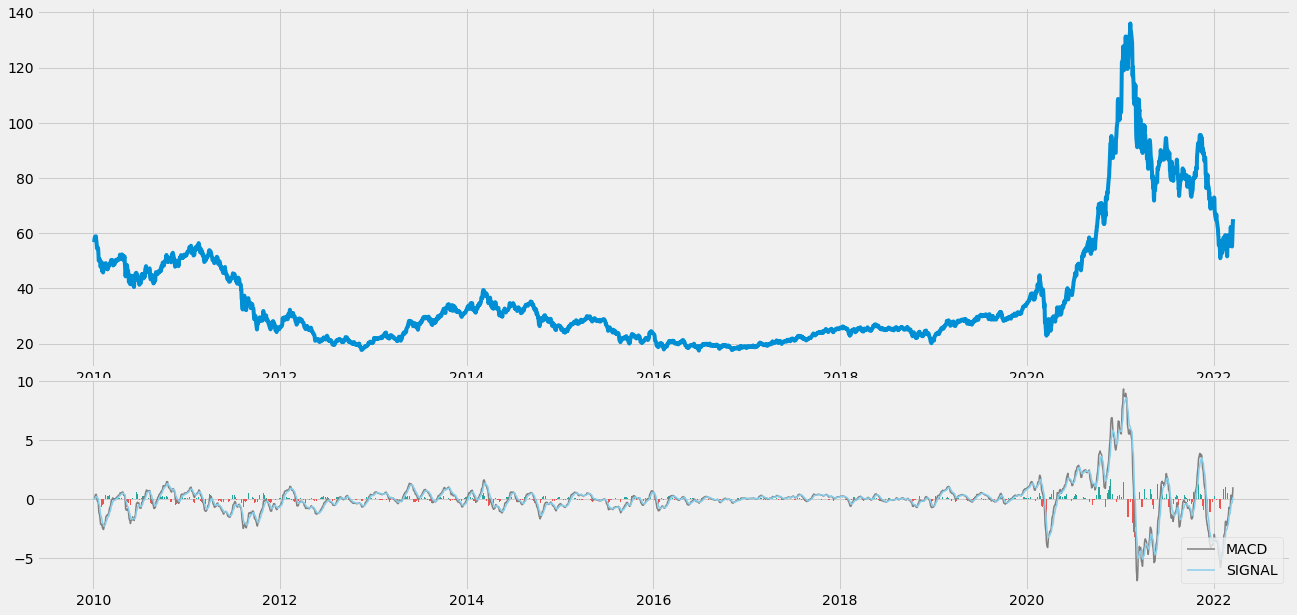

In [15]:
def plot_macd(prices, MACD, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(MACD, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['Close'], df['macd'], df['signal'], df['hist'])

### Price Rate of Change (ROC) 

In [16]:
def ROC(data,n):
 N=data['Close'].diff(n)
 D=data['Close'].shift(n)
 ROC=pd.Series(N/D,name='Rate of Change')
 data=data.join(ROC)
 return data

In [17]:
n=5
ROC_Nifty=ROC(data,n)
ROC=ROC_Nifty['Rate of Change']

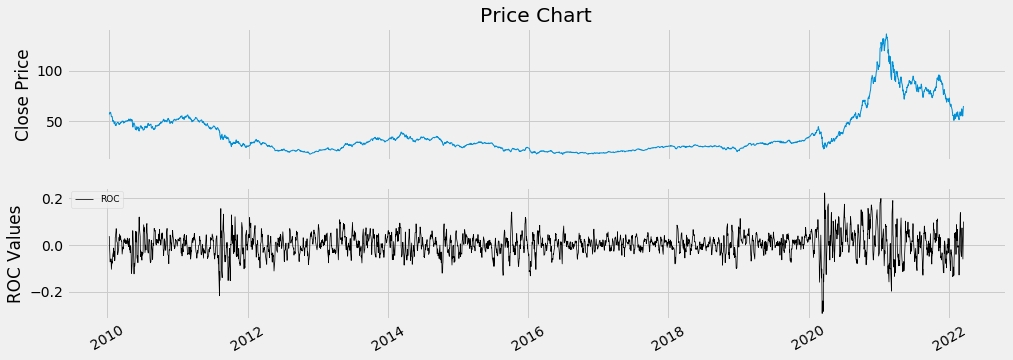

In [18]:
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(2,1,1)
ax.set_xticklabels([])
plt.plot(data['Close'],lw=1)
plt.title('Price Chart')
plt.ylabel('Close Price')
plt.grid(True)
bx=fig.add_subplot(2,1,2)
plt.plot(ROC,'k',lw=0.75,linestyle='-',label='ROC')
plt.legend(loc=2,prop={'size':9})
plt.ylabel('ROC Values')
plt.grid(True)
plt.setp(plt.gca().get_xticklabels(),rotation=30)
plt.show()

### On-Balance Volume (OBV)

In [19]:
def add_obv(df):
    df['OBV'] = (np.sign(df["Close"].diff()) * df["Volume"]).fillna(0).cumsum()
    return df

In [20]:
df = add_obv(df)

In [21]:
def plot_obv(df):    

    obv_addplot = mpf.make_addplot(df["OBV"], width=2, panel=2, ylabel="OBV")
    
    mpf.plot(
        df,
        addplot=obv_addplot,
        type="candle",
        title="Price and On-Balance Volume",
        ylabel="Price ($)",
        volume=True,
        ylabel_lower="Volume",
        show_nontrading=False,
        style="yahoo",
        figsize=(15, 6),
        panel_ratios=(3, 1, 2),
        datetime_format="%Y-%m-%d")

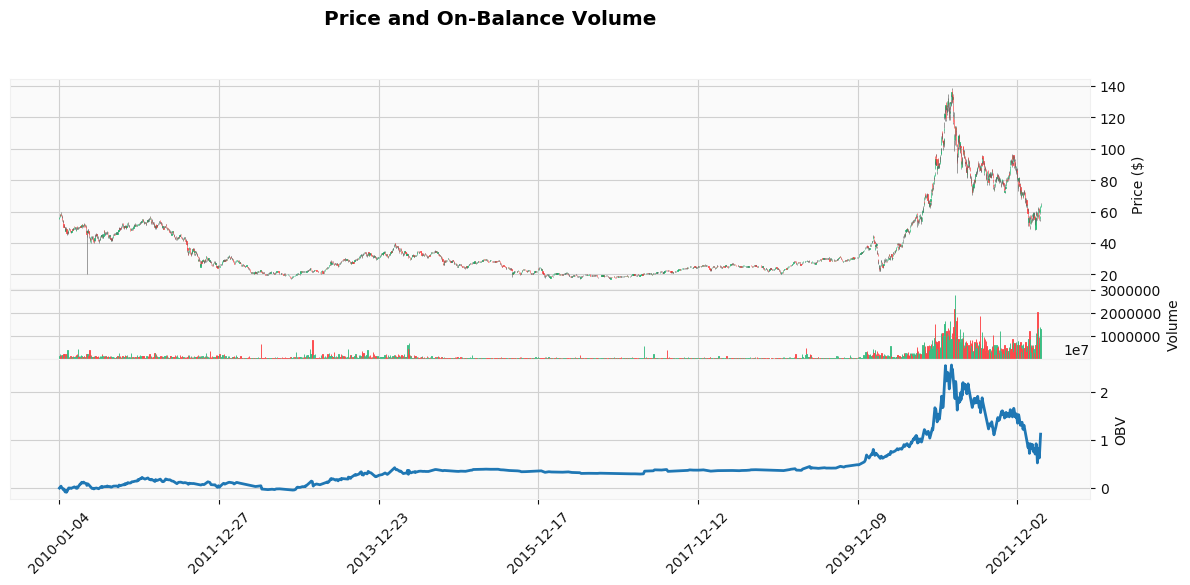

In [22]:
plot_obv(df)

### 200-Day Moving Average

In [23]:
df['SMA_200'] = df['Close'].rolling(window=200).mean()

In [24]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,RSI,%K,%D,AD_Line,macd,signal,hist,OBV,SMA_200
Date,,,,,,,,,,,,,,,
2010-01-04,55.450001,56.750000,55.450001,56.750000,43.456402,107960,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,NaN
2010-01-05,56.849998,57.750000,56.450001,57.400002,43.954155,101740,100.00,NaN,NaN,1.75,0.051852,0.010370,0.041482,101740.0,NaN
2010-01-06,57.500000,58.549999,57.450001,58.250000,44.605030,181180,100.00,NaN,NaN,2.40,0.159692,0.040235,0.119457,282920.0,NaN
2010-01-07,58.250000,58.400002,57.700001,58.099998,44.490170,97420,98.29,NaN,NaN,2.25,0.230396,0.078267,0.152129,185500.0,NaN
2010-01-08,58.000000,58.799999,58.000000,58.799999,45.026192,75240,98.43,NaN,NaN,3.15,0.339006,0.130415,0.208591,260740.0,NaN
2010-01-11,59.250000,59.750000,58.400002,58.849998,45.064476,138800,98.44,NaN,NaN,2.30,0.424225,0.189177,0.235048,399540.0,NaN
2010-01-12,58.250000,58.250000,57.000000,57.400002,43.954155,157560,82.81,NaN,NaN,2.05,0.370488,0.225439,0.145049,241980.0,NaN
2010-01-13,57.250000,57.400002,56.000000,57.099998,43.724419,147420,79.98,NaN,NaN,2.05,0.300232,0.240398,0.059834,94560.0,NaN
2010-01-14,57.099998,57.700001,55.750000,55.849998,42.767227,78200,69.35,NaN,NaN,0.80,0.142052,0.220728,-0.078677,16360.0,NaN
